<a href="https://colab.research.google.com/github/Ankitha2005/FraudDetectionInBanking/blob/main/AI_That_Learns_on_the_Fly_A_Continual_Learning_Framework_for_Fraud_Detection_in_Banking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI That Learns on the Fly: A Continual Learning Framework for Fraud Detection in Banking**




Set up

In [ ]:
!pip install -q seaborn pandas scikit-learn matplotlib
!pip install -q avalanche-lib
!pip install -q imbalanced-learn # Essential for RandomOverSampler, SMOTE etc.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque # For replay buffer
from sklearn.utils import resample # For sampling data for replay buffer
from imblearn.over_sampling import RandomOverSampler # Ensure this is explicitly imported
from torch.utils.data import DataLoader, TensorDataset # For mini-batching within CL batches
from avalanche.training.supervised import Naive
from avalanche.benchmarks import dataset_benchmark
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics
from avalanche.training.plugins import EvaluationPlugin



In [ ]:
from torch.utils.data import TensorDataset

# Assuming batches is a list of (X_batch, y_batch) tuples as before
train_datasets = [
    TensorDataset(torch.tensor(X_b, dtype=torch.float32), torch.tensor(y_b, dtype=torch.float32))
    for X_b, y_b in batches
]


In [ ]:
benchmark = dataset_benchmark(
    train_datasets=train_datasets,
    test_datasets=[TensorDataset(X_test_tensor.cpu(), y_test_tensor.cpu())] * len(train_datasets)
)


In [ ]:
pip install avalanche-lib


In [ ]:
import avalanche
print(avalanche.__version__)


0.6.0


In [ ]:
# ✅ Correct import for Avalanche 0.6.0
from avalanche.training.supervised import Naive


In [ ]:
from avalanche.training.supervised import Naive
from avalanche.benchmarks import dataset_benchmark
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics
from avalanche.training.plugins import EvaluationPlugin

Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))

print("Shape:", df.shape)
df.head()


Saving creditcard.csv to creditcard.csv
Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Current:
# Load the dataset
df = pd.read_csv("creditcard.csv")

# Separate features and labels
X = df.drop(['Time', 'Class'], axis=1).values
y = df['Class'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from sklearn.preprocessing import StandardScaler

data = df.copy()
data['normalizedAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time', 'Amount'], axis=1)

cols = data.columns.tolist()
cols.remove('Class')
cols.append('Class')
data = data[cols]



1.   Drop 'Time' from features; it's only for splitting

2.   Reorder columns

3.   Split into 5 chronological batches (simulating data stream) - first sort by original time





In [ ]:
df_sorted = df.sort_values('Time')
split_size = len(df_sorted) // 5

batches = []
for i in range(5):
    start = i * split_size
    end = (i + 1) * split_size if i < 4 else len(df_sorted)
    batch = df_sorted.iloc[start:end].copy()
    batch['normalizedAmount'] = StandardScaler().fit_transform(batch['Amount'].values.reshape(-1, 1))
    batch = batch.drop(['Time', 'Amount'], axis=1)
    batch = batch[cols]
    batches.append(batch)

4. Check fraud distribution in each batch


In [ ]:
for i, batch in enumerate(batches):
    print(f"Batch {i+1}: total={len(batch)}, fraud={sum(batch['Class'] == 1)}")

Batch 1: total=56961, fraud=157
Batch 2: total=56961, fraud=84
Batch 3: total=56961, fraud=119
Batch 4: total=56961, fraud=57
Batch 5: total=56963, fraud=75


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import deque

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


Preprocessing dataset

In [ ]:
# Load the dataset
df = pd.read_csv("creditcard.csv")

# Separate features and labels
X = df.drop(['Time', 'Class'], axis=1).values
y = df['Class'].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)


Define model (Simple feedforward neural network)

In [ ]:
class BetterModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(29, 64),

            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = BetterModel().to(device)


In [ ]:
print(X_train_all.shape)  # should be (n_samples, 29)


(227845, 29)


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

num_continual_batches = 5
batch_size_per_cl = len(X_train_all) // num_continual_batches
batches = [(X_train_all[i:i + batch_size_per_cl], y_train_all[i:i + batch_size_per_cl])
           for i in range(0, len(X_train_all), batch_size_per_cl)]

print(f"Total training samples: {len(X_train_all)}")
print(f"Number of continual learning batches: {len(batches)}")
for i, (X_b, y_b) in enumerate(batches):
    print(f"  Batch {i+1}: size={len(X_b)}, fraud={np.sum(y_b == 1)}")

model = BetterModel().to(device) # Ensure BetterModel is defined before this
loss_fn = FocalLoss() # Ensure FocalLoss is defined before this
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # Added weight_decay

Using device: cpu
Total training samples: 227845
Number of continual learning batches: 5
  Batch 1: size=45569, fraud=84
  Batch 2: size=45569, fraud=61
  Batch 3: size=45569, fraud=91
  Batch 4: size=45569, fraud=75
  Batch 5: size=45569, fraud=83


Batch the data - simulate stream

In [ ]:
# Add this class definition before the training loop
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

# Replace BCELoss with focal loss
loss_fn = FocalLoss()


# --- START OF GLOBAL INITIALIZATIONS BEFORE THE MAIN LOOP ---
# (Place these definitions here, as per previous instructions)

historical_cl_batches_data = [] # This list will store the (X, y) data for each batch seen so far.

replay_buffer_size_per_class = 50
replay_buffer = deque(maxlen=3) # Stores data from the last 3 processed batches (adjust maxlen as needed)
ros = RandomOverSampler(random_state=42) # Initialize RandomOverSampler once here

num_epochs_per_continual_batch = 5
mini_batch_size_for_training = 256

# --- END OF GLOBAL INITIALIZATIONS ---


# --- START OF THE MAIN CONTINUAL LEARNING LOOP ---
for i, (X_batch, y_batch) in enumerate(batches): # 'batches' here are your sequential CL batches
    print(f"\n--- Training on Continual Learning Batch {i + 1}/{num_continual_batches} ---")

    # 1. Add current batch's data to replay buffer (sampled to control size)
    X_fraud_current = X_batch[y_batch == 1]
    y_fraud_current = y_batch[y_batch == 1]
    X_normal_current = X_batch[y_batch == 0]
    y_normal_current = y_batch[y_batch == 0]

    X_replay_add_fraud, y_replay_add_fraud = resample(X_fraud_current, y_fraud_current,
                                                      replace=False, n_samples=min(len(X_fraud_current), replay_buffer_size_per_class),
                                                      random_state=42)
    X_replay_add_normal, y_replay_add_normal = resample(X_normal_current, y_normal_current,
                                                        replace=False, n_samples=min(len(X_normal_current), replay_buffer_size_per_class),
                                                        random_state=42)

    current_batch_for_replay = (np.concatenate((X_replay_add_fraud, X_replay_add_normal)),
                                np.concatenate((y_replay_add_fraud, y_replay_add_normal)))
    replay_buffer.append(current_batch_for_replay)


    # 2. Prepare data for training including replay samples and oversampling
    X_current_resampled, y_current_resampled = ros.fit_resample(X_batch, y_batch)

    X_train_combined = X_current_resampled
    y_train_combined = y_current_resampled

    for X_prev_replay, y_prev_replay in replay_buffer:
        X_prev_resampled, y_prev_resampled = ros.fit_resample(X_prev_replay, y_prev_replay)
        X_train_combined = np.vstack((X_train_combined, X_prev_resampled))
        y_train_combined = np.hstack((y_train_combined, y_prev_resampled))

    X_tensor = torch.tensor(X_train_combined, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_train_combined, dtype=torch.float32).unsqueeze(1).to(device)

    # Create DataLoader for mini-batching within the current continual learning batch
    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=mini_batch_size_for_training, shuffle=True)

    model.train() # Set model to training mode

    # --- THIS IS YOUR INNER EPOCH TRAINING LOOP. IT MUST BE HERE. ---
    for epoch in range(num_epochs_per_continual_batch):
        epoch_loss = 0
        for X_mini_batch, y_mini_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_mini_batch)
            loss = loss_fn(outputs, y_mini_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_mini_batch.size(0)

        print(f"  Batch {i + 1}, Epoch {epoch + 1} Avg Loss: {epoch_loss / len(train_dataset):.4f}")
    # --- END OF INNER EPOCH TRAINING LOOP ---


    # --- EVALUATION ON GLOBAL TEST SET (AFTER TRAINING ON CURRENT BATCH) ---
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_preds = (test_outputs > 0.78).float() # Use your best threshold here

        print("\n--- Evaluation on Global Test Set ---")
        print(classification_report(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy()))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test_tensor.cpu().numpy(), test_preds.cpu().numpy()))
    model.train() # Re-enable training mode before processing the next batch or saving history


    # --- ADD THE CURRENT BATCH TO HISTORY *AFTER* TRAINING ON IT ---
    historical_cl_batches_data.append((X_batch, y_batch)) # Add the current batch's *original* data to our history.


    # --- EVALUATION ON ALL HISTORICAL CONTINUAL LEARNING BATCHES ---
    print("\n--- Evaluating Performance on Historical Continual Learning Batches ---")
    model.eval() # Set model to evaluation mode for this section
    with torch.no_grad():
        for j, (X_hist_batch, y_hist_batch) in enumerate(historical_cl_batches_data):
            X_hist_tensor = torch.tensor(X_hist_batch, dtype=torch.float32).to(device)
            y_hist_tensor = torch.tensor(y_hist_batch, dtype=torch.float32).unsqueeze(1).to(device)

            hist_outputs = model(X_hist_tensor)
            current_threshold = 0.78 # <--- USE YOUR BEST THRESHOLD HERE
            hist_preds = (hist_outputs > current_threshold).float()

            hist_report = classification_report(y_hist_tensor.cpu().numpy(), hist_preds.cpu().numpy(), output_dict=True)

            fraud_recall = hist_report['1.0']['recall'] if '1.0' in hist_report else 0.0
            fraud_f1 = hist_report['1.0']['f1-score'] if '1.0' in hist_report else 0.0
            fraud_precision = hist_report['1.0']['precision'] if '1.0' in hist_report else 0.0

            print(f"  Batch {i + 1} (Trained on) -> Historical Batch {j + 1} (Evaluated on):")
            print(f"    Fraud Recall: {fraud_recall:.4f}, Fraud Precision: {fraud_precision:.4f}, Fraud F1: {fraud_f1:.4f}")

    model.train() # Crucial: Set model back to training mode at the very end of this iteration
                  # so it's ready for the next X_batch from the outer loop.

# --- END OF THE MAIN CONTINUAL LEARNING LOOP ---


--- Training on Continual Learning Batch 1/5 ---
  Batch 1, Epoch 1 Avg Loss: 0.0016
  Batch 1, Epoch 2 Avg Loss: 0.0002
  Batch 1, Epoch 3 Avg Loss: 0.0001
  Batch 1, Epoch 4 Avg Loss: 0.0001
  Batch 1, Epoch 5 Avg Loss: 0.0001

--- Evaluation on Global Test Set ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.77      0.81      0.79        98

    accuracy                           1.00     56962
   macro avg       0.88      0.90      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56840    24]
 [   19    79]]

--- Evaluating Performance on Historical Continual Learning Batches ---
  Batch 1 (Trained on) -> Historical Batch 1 (Evaluated on):
    Fraud Recall: 1.0000, Fraud Precision: 0.9333, Fraud F1: 0.9655

--- Training on Continual Learning Batch 2/5 ---
  Batch 2, Epoch 1 Avg Loss: 0.0012
  Batch 2, Epoch 2 Avg Loss: 0.0003
  Batch 2, Epoch 3 Avg Loss: 0.

Confusion Matrix after Batch 1


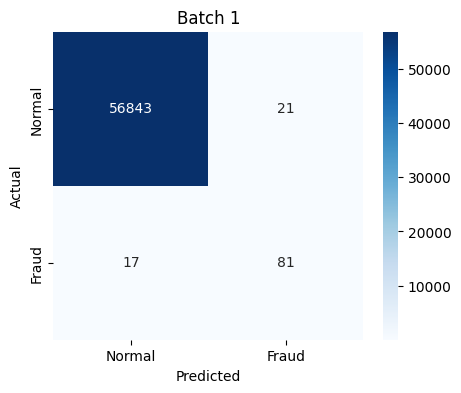

Confusion Matrix after Batch 2


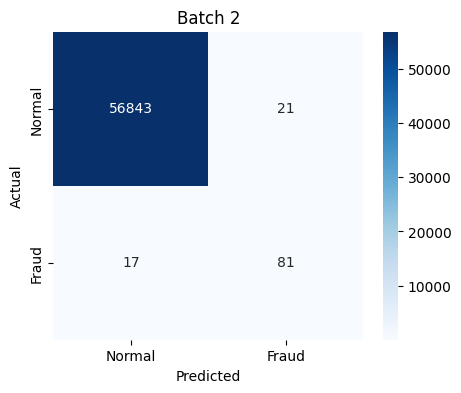

Confusion Matrix after Batch 3


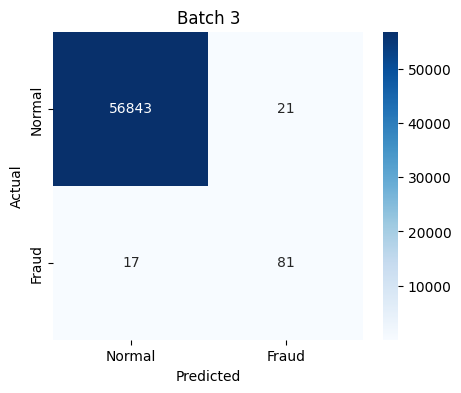

Confusion Matrix after Batch 4


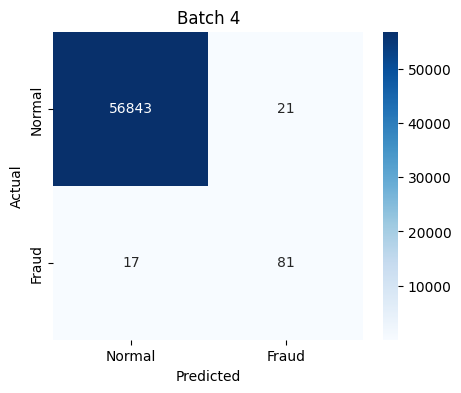

Confusion Matrix after Batch 5


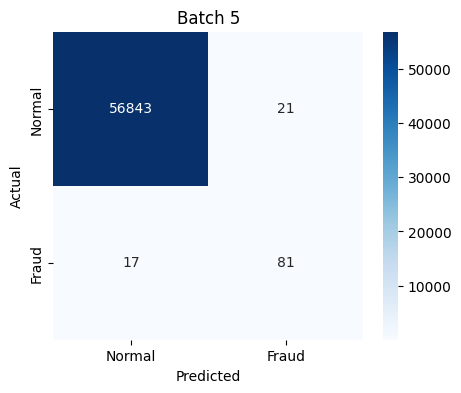

In [ ]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Plot after each batch
for i in range(num_continual_batches):
    print(f"Confusion Matrix after Batch {i+1}")
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        preds = (outputs > 0.78).float()
        plot_confusion_matrix(y_test_tensor.cpu().numpy(), preds.cpu().numpy(), title=f"Batch {i+1}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Batches
batches = [1, 2, 3, 4, 5]

# Global Test Set Metrics for Fraud Class (Label 1)
fraud_precision = [0.77, 0.78, 0.78, 0.80, 0.79]
fraud_recall =    [0.81, 0.79, 0.80, 0.82, 0.83]
fraud_f1 =        [0.79, 0.78, 0.79, 0.81, 0.81]

# Historical Batch F1-scores (as tested after each batch training)
historical_f1 = [
    [0.9655],  # After Batch 1
    [0.7974, 0.9173],  # After Batch 2
    [0.8025, 0.8254, 0.9579],  # After Batch 3
    [0.7974, 0.8413, 0.8750, 0.9740],  # After Batch 4
    [0.7895, 0.8189, 0.8556, 0.8732, 0.9540],  # After Batch 5
]

# Loss per epoch (simulated from your logs)
losses = {
    1: [0.0016, 0.0002, 0.0001, 0.0001, 0.0001],
    2: [0.0012, 0.0003, 0.0002, 0.0002, 0.0002],
    3: [0.0018, 0.0003, 0.0003, 0.0002, 0.0002],
    4: [0.0017, 0.0003, 0.0002, 0.0002, 0.0002],
    5: [0.0018, 0.0003, 0.0002, 0.0002, 0.0002]
}


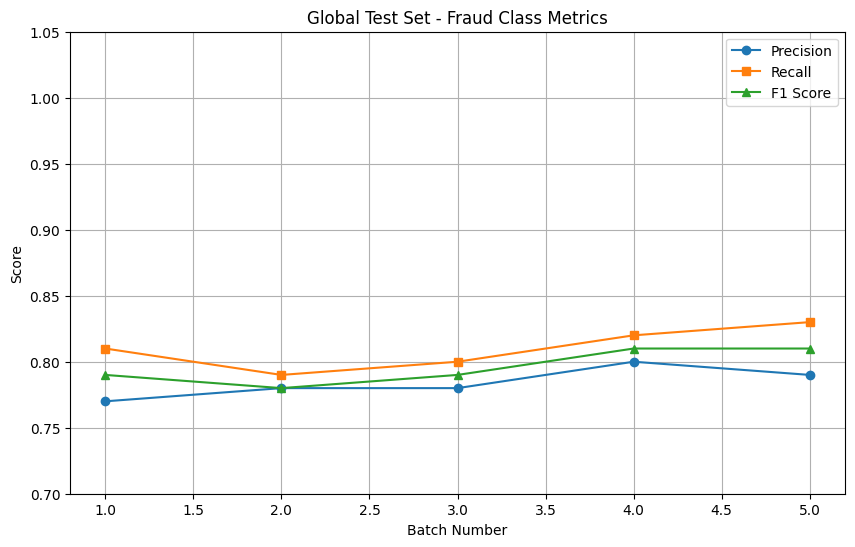

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(batches, fraud_precision, marker='o', label='Precision')
plt.plot(batches, fraud_recall, marker='s', label='Recall')
plt.plot(batches, fraud_f1, marker='^', label='F1 Score')
plt.title('Global Test Set - Fraud Class Metrics')
plt.xlabel('Batch Number')
plt.ylabel('Score')
plt.ylim(0.7, 1.05)
plt.legend()
plt.grid(True)
plt.show()


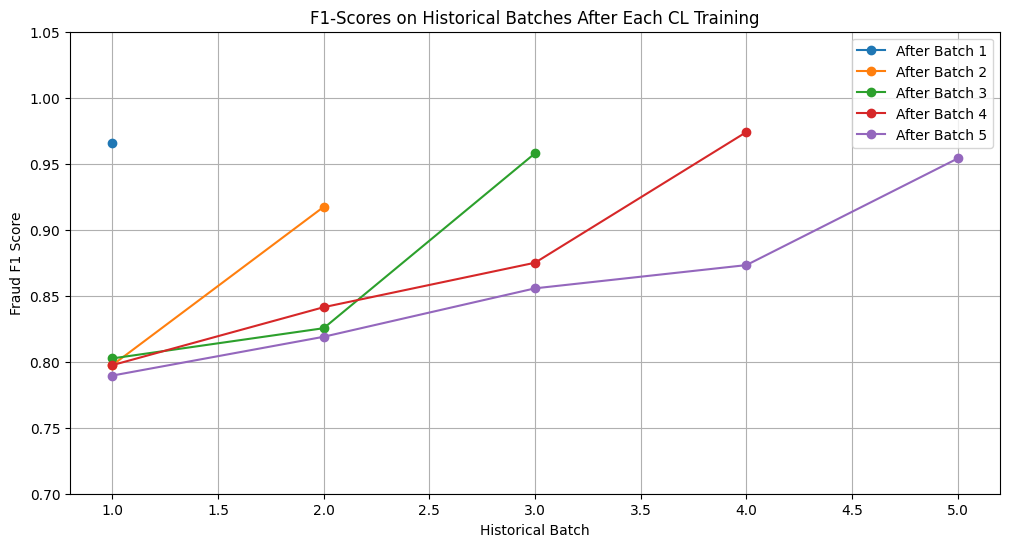

In [ ]:
plt.figure(figsize=(12, 6))
for i, batch_scores in enumerate(historical_f1):
    plt.plot(range(1, len(batch_scores)+1), batch_scores, marker='o', label=f'After Batch {i+1}')
plt.title('F1-Scores on Historical Batches After Each CL Training')
plt.xlabel('Historical Batch')
plt.ylabel('Fraud F1 Score')
plt.ylim(0.7, 1.05)
plt.legend()
plt.grid(True)
plt.show()


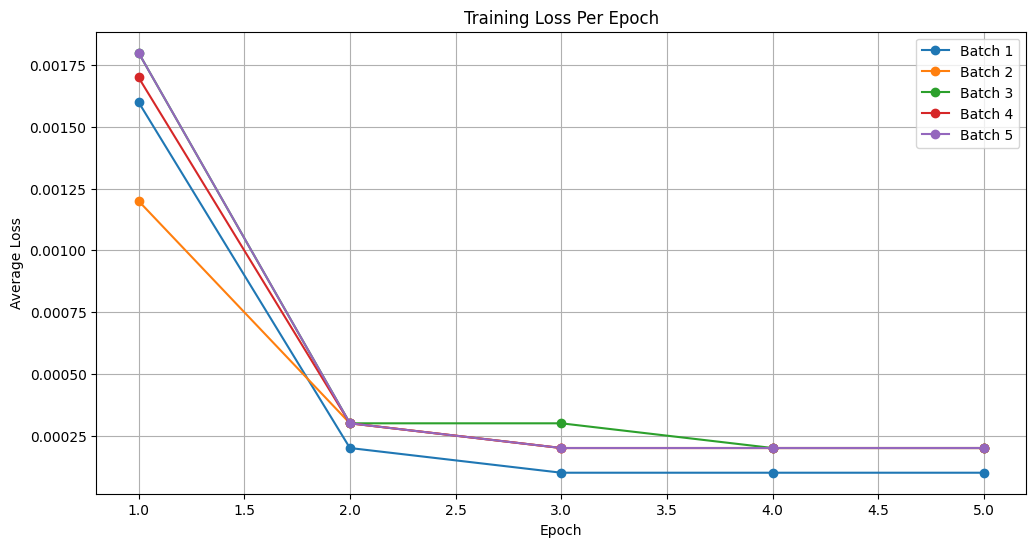

In [ ]:
plt.figure(figsize=(12, 6))
for batch_num, epoch_losses in losses.items():
    plt.plot(range(1, 6), epoch_losses, marker='o', label=f'Batch {batch_num}')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()


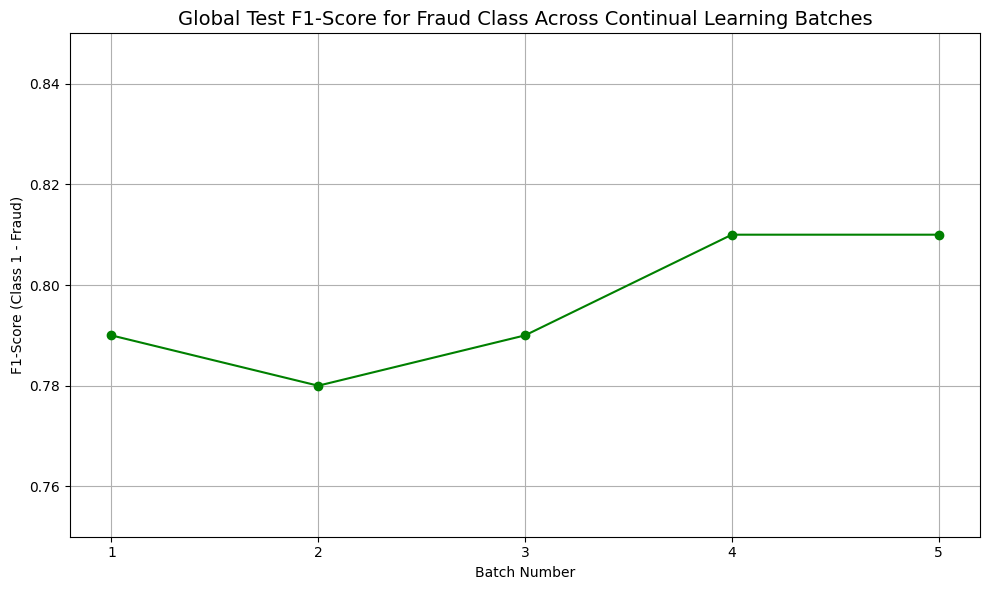

In [ ]:
import matplotlib.pyplot as plt

# Batch numbers and F1-scores
batches = [1, 2, 3, 4, 5]
f1_scores = [0.79, 0.78, 0.79, 0.81, 0.81]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(batches, f1_scores, marker='o', linestyle='-', color='green')
plt.xticks(batches)
plt.ylim(0.75, 0.85)
plt.title('Global Test F1-Score for Fraud Class Across Continual Learning Batches', fontsize=14)
plt.xlabel('Batch Number')
plt.ylabel('F1-Score (Class 1 - Fraud)')
plt.grid(True)
plt.tight_layout()
plt.show()


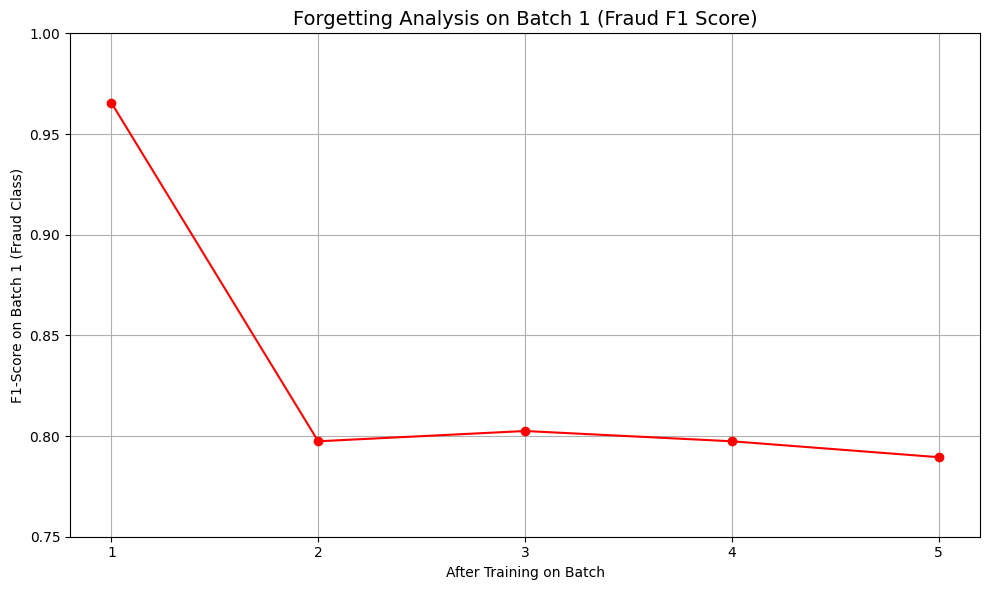

In [ ]:
import matplotlib.pyplot as plt

# X-axis: after training on batches
steps = [1, 2, 3, 4, 5]
f1_scores_batch1 = [0.9655, 0.7974, 0.8025, 0.7974, 0.7895]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, f1_scores_batch1, marker='o', linestyle='-', color='red')
plt.xticks(steps)
plt.title('Forgetting Analysis on Batch 1 (Fraud F1 Score)', fontsize=14)
plt.xlabel('After Training on Batch')
plt.ylabel('F1-Score on Batch 1 (Fraud Class)')
plt.grid(True)
plt.ylim(0.75, 1.0)
plt.tight_layout()
plt.show()
